In [1]:
import sys
%load_ext autoreload
%autoreload 2
sys.path.append('..')

import numpy as np
import random
import torch

from pytorch_pretrained_bert.tokenization import BertTokenizer

from lib import data_processors, tasks
from lib.bert import BertForSequenceClassification
from lib.train_eval import train, evaluate, predict

torch.cuda.is_available()

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


True

In [2]:
# %env CUDA_VISIBLE_DEVICES=1

params = {
    'data_dir': '../../../data/SST-2', # changed
    'output_dir': '../output',
    'cache_dir': '../model_cache',
    'task_name': 'sst2',
    'bert_model': 'bert-base-uncased',
    'max_seq_length': 128,
    'train_batch_size': 12,
    'eval_batch_size': 8,
    'learning_rate': 2e-5,
    'warmup_proportion': 0.1,
    'num_train_epochs': 1,
    'seed': 1331,
    'device': torch.device(
        'cuda' if torch.cuda.is_available()
        else 'cpu')
}

random.seed(params['seed'])
np.random.seed(params['seed'])
torch.manual_seed(params['seed'])

In [3]:
from lib.l0reg.modules import L0LinearWrapper, L0Linear, L0Conv2dWrapper, L0Conv2d

In [4]:
from torch import nn

def l0_wrapper(layer):
    if isinstance(layer, nn.Linear):
        return L0LinearWrapper(layer)
    if isinstance(layer, nn.Conv2d):
        return L0Conv2dWrapper(layer)
    return layer

In [5]:
def l0_wrap_bert_layer(bert_layer):
    bert_layer.attention.self.query = l0_wrapper(bert_layer.attention.self.query)
    bert_layer.attention.self.key = l0_wrapper(bert_layer.attention.self.key)
    bert_layer.attention.self.value = l0_wrapper(bert_layer.attention.self.value)
    bert_layer.attention.output.dense = l0_wrapper(bert_layer.attention.output.dense)
    bert_layer.intermediate.dense = l0_wrapper(bert_layer.intermediate.dense)
    bert_layer.output.dense = l0_wrapper(bert_layer.output.dense)
    return bert_layer

def l0_penalty_bert_layer(bert_layer):
    penalty = bert_layer.attention.self.query.penalty
    penalty += bert_layer.attention.self.key.penalty
    penalty += bert_layer.attention.self.value.penalty
    penalty += bert_layer.attention.output.dense.penalty
    penalty += bert_layer.intermediate.dense.penalty
    penalty += bert_layer.output.dense.penalty
    return penalty

def num_zeroed(l0_linear_layer):
    return (l0_linear_layer._get_mask()[0].cpu().data.numpy() == 0).sum()

def num_zeroed_bert_layer(bert_layer):
    n = num_zeroed(bert_layer.attention.self.query)
    n += num_zeroed(bert_layer.attention.self.key)
    n += num_zeroed(bert_layer.attention.self.value)
    n += num_zeroed(bert_layer.attention.output.dense)
    n += num_zeroed(bert_layer.intermediate.dense)
    n += num_zeroed(bert_layer.output.dense)
    return n

In [6]:
class BertL0Encoder(nn.Module):
    def __init__(self, bert_encoder):
        super(BertL0Encoder, self).__init__()
        self.l0_indices = [11]
        self.encoder = bert_encoder
        for i in self.l0_indices:
            self.encoder.layer[i] = l0_wrap_bert_layer(self.encoder.layer[i])
    
    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        penalty = 0
        for i, layer_module in enumerate(self.encoder.layer):
            hidden_states = layer_module(hidden_states, attention_mask)
            if i in self.l0_indices:
                penalty += l0_penalty_bert_layer(layer_module)
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        return all_encoder_layers, penalty
    
    def num_zeroed(self):
        n = 0
        for i in self.l0_indices:
            n += num_zeroed_bert_layer(self.encoder.layer[i])
        return n

In [7]:
class BertL0Model(nn.Module):
    def __init__(self, bert_model):
        super(BertL0Model, self).__init__()
        self.model = bert_model
        self.model.encoder = BertL0Encoder(self.model.encoder)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(
            dtype=next(self.model.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.model.embeddings(input_ids, token_type_ids)
        encoded_layers, penalty = self.model.encoder(
            embedding_output,
            extended_attention_mask,
            output_all_encoded_layers=output_all_encoded_layers
        )
        sequence_output = encoded_layers[-1]
        pooled_output = self.model.pooler(sequence_output)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return encoded_layers, pooled_output, penalty
    
    def num_zeroed(self):
        return self.model.encoder.num_zeroed()

In [8]:
from torch.nn import CrossEntropyLoss
from lib.bert import BertForSequenceClassification

class BertL0ForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config, num_labels, l0=1):
        super(BertL0ForSequenceClassification, self).__init__(config, num_labels)
        self.l0 = l0
        
    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path,
                        l0=1, state_dict=None, cache_dir=None,
                        from_tf=False, *inputs, **kwargs):
        model = super(BertL0ForSequenceClassification, cls).from_pretrained(
            pretrained_model_name_or_path, state_dict=state_dict,
            cache_dir=cache_dir, from_tf=from_tf, *inputs, **kwargs)
        model.l0 = l0
        return model
    
    def wrap(self):
        self.bert = BertL0Model(self.bert)
        return self
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output, penalty = self.bert(
            input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1)) + self.l0 * penalty
            return loss
        else:
            return logits
        
    def num_zeroed(self):
        return self.bert.num_zeroed()

In [9]:
params['num_labels'] = tasks.num_labels[params['task_name']]
params['label_list'] = tasks.label_lists[params['task_name']]

processor = tasks.processors[params['task_name']]()
tokenizer = BertTokenizer.from_pretrained(
    params['bert_model'], do_lower_case=True)

train_examples = processor.get_train_examples(params['data_dir'])
dev_examples = processor.get_dev_examples(params['data_dir'])
model = BertL0ForSequenceClassification.from_pretrained(
    params['bert_model'],
    cache_dir=params['cache_dir'],
    num_labels=params['num_labels']).wrap().cuda()

In [10]:
import os
import torch
import random
import numpy as np
from tqdm import tqdm_notebook
from torch.utils.data import (
    DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from pytorch_pretrained_bert.optimization import BertAdam
from pytorch_pretrained_bert.modeling import BertConfig

from lib import feature_processors, metrics
from lib.bert import BertForSequenceClassification


def train(model, tokenizer, params,
          train_examples,
          valid_examples=None,
          checkpoint_files={'config': 'bert_config.json',
                            'model_weigths': 'model_trained.pth'}):
    global DANCING
    
    random.seed(params['seed'])
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    
    train_steps_per_epoch = int(len(train_examples) / params['train_batch_size'])
    num_train_optimization_steps = train_steps_per_epoch * params['num_train_epochs']

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer
                    if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer
                    if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]
    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=params['learning_rate'],
                         warmup=params['warmup_proportion'],
                         t_total=num_train_optimization_steps)
    
    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0
    
    train_features = feature_processors.convert_examples_to_features(
        train_examples,
        params['label_list'],
        params['max_seq_length'],
        tokenizer)
    print("***** Running training *****")
    print("Num examples:",  len(train_examples))
    print("Batch size:  ", params['train_batch_size'])
    print("Num steps:   ", num_train_optimization_steps)
    all_input_ids = torch.tensor(
        [f.input_ids for f in train_features],
         dtype=torch.long)
    all_input_mask = torch.tensor(
        [f.input_mask for f in train_features],
         dtype=torch.long)
    all_segment_ids = torch.tensor(
        [f.segment_ids for f in train_features],
         dtype=torch.long)
    all_label_ids = torch.tensor(
        [f.label_id for f in train_features],
         dtype=torch.long)
    train_data = TensorDataset(all_input_ids,
                               all_input_mask,
                               all_segment_ids,
                               all_label_ids)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(
        train_data, sampler=train_sampler,
        batch_size=params['train_batch_size'])

    model.train()
    for epoch_num in range(int(params['num_train_epochs'])):
        print('\nEpoch: {}'.format(epoch_num + 1))
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
            batch = tuple(t.to(params['device']) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            loss = model(input_ids, segment_ids, input_mask, label_ids)
            loss.backward()
            
            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

        train_result = {
            'train_loss': tr_loss / nb_tr_steps,
            'train_global_step': global_step,
        }
        print(train_result)
        if valid_examples is not None:
            valid_result, valid_prob_preds = evaluate(
                model, tokenizer, params, valid_examples)
            print('0s:', model.num_zeroed())
            print('min:',
                  model.bert.model.encoder.encoder.layer[11].attention.self.key._get_mask()[0].min())
            DANCING.append(
                (model.num_zeroed(),
                 model.bert.model.encoder.encoder.layer[11].attention.self.key._get_mask()[0].min(),
                 valid_result))
            print(valid_result)
            model.train()

    if not os.path.exists(params['output_dir']):
        os.makedirs(params['output_dir'])
    model_to_save = model.module if hasattr(model, 'module') else model
    output_model_file = os.path.join(params['output_dir'],
                                     checkpoint_files['file_to_save'])
    torch.save(model_to_save.state_dict(), output_model_file)
    output_config_file = os.path.join(params['output_dir'],
                                      checkpoint_files['config'])
    with open(output_config_file, 'w') as f:
        f.write(model_to_save.config.to_json_string())

    train_result = {
        'train_loss': tr_loss / nb_tr_steps,
        'train_global_step': global_step,
    }
    
    
    return model, train_result

In [11]:
model.l0 = 1e10

In [13]:
EPOCH_NUM = 1

params['num_train_epochs'] = 10
checkpoint_files = {
    'config': 'bert_config.json',
    'file_to_save': 'model_{}_epoch_{}.pth'.format(
        params['task_name'], EPOCH_NUM)
}

model, result = train(model, tokenizer, params,
                      train_examples,
                      valid_examples=dev_examples,
                      checkpoint_files=checkpoint_files)
result

***** Running training *****
Num examples: 67349
Batch size:   12
Num steps:    56120

Epoch: 1


KeyboardInterrupt: 

In [14]:
torch.cuda.max_memory_allocated() / 1024 / 1024

4302.9189453125

In [99]:
min_elem = [
    0.4678, 0.4394, 0.4164, 0.3934, 0.38, 0.3613, 0.345, 0.34, 0.3378, 0.315,
    0.306, 0.2947, 0.2746, 0.2546, 0.24105, 0.2275, 0.2183, 0.212, 0.2081, 0.2068,
    0.1938, 0.1734, 0.1563, 0.1421, 0.1305, 0.1214, 0.1145, 0.1097, 0.1069, 0.1059
]
for _, m, _ in DANCING:
    min_elem.append(float(m.data.cpu().numpy()))

In [90]:
(0.2546 + 0.2275) / 2

0.24105

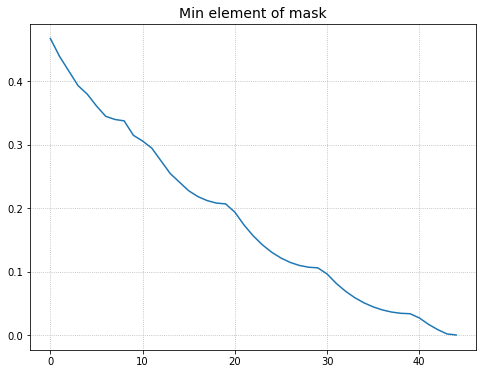

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.plot(min_elem)
plt.title("Min element of mask", fontsize=14)
plt.grid(ls=":")
plt.show()

In [71]:
min_elem

[0.4678,
 0.4394,
 0.41,
 0.3934,
 0.38,
 0.3613,
 0.35,
 0.34,
 0.3378,
 0.32,
 0.31,
 0.2947,
 0.27,
 0.2546,
 0.23,
 0.2275,
 0.2183,
 0.212,
 0.2081,
 0.2068,
 0.1938,
 0.1734,
 0.1563,
 0.1421,
 0.1305,
 0.1214,
 0.1145,
 0.1097,
 0.1069,
 0.1059,
 0.09624987095594406,
 0.08134373277425766,
 0.06899028271436691,
 0.05886765569448471,
 0.050713829696178436,
 0.04431476444005966,
 0.03950249403715134,
 0.036153219640254974,
 0.03418009728193283,
 0.03352943807840347,
 0.02690904587507248,
 0.016768820583820343,
 0.008439145982265472,
 0.0016614049673080444,
 0.0]

In [13]:
EPOCH_NUM = 1

params['num_train_epochs'] = 10
checkpoint_files = {
    'config': 'bert_config.json',
    'file_to_save': 'model_{}_epoch_{}.pth'.format(
        params['task_name'], EPOCH_NUM)
}

model, result = train(model, tokenizer, params,
                      train_examples,
                      valid_examples=dev_examples,
                      checkpoint_files=checkpoint_files)
result

***** Running training *****
Num examples: 67349
Batch size:   12
Num steps:    56120

Epoch: 1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed


{'train_loss': 43634561834.00535, 'train_global_step': 11226}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.23it/s]


0s: 0
min: tensor(0.2947, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.8950227023856846, 'eval_accuracy': 0.8681192660550459, 'eval_f1_score': 0.8815653964984552, 'eval_matthews_corrcoef': 0.7490285297671831}

Epoch: 3


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




{'train_loss': 41574228103.00089, 'train_global_step': 22452}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.20it/s]


0s: 0
min: tensor(0.2546, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.6675180818107971, 'eval_accuracy': 0.9059633027522935, 'eval_f1_score': 0.9100877192982456, 'eval_matthews_corrcoef': 0.8129088273674456}

Epoch: 5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




{'train_loss': 39977772242.71085, 'train_global_step': 33678}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.22it/s]


0s: 0
min: tensor(0.2275, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.8225862858146175, 'eval_accuracy': 0.9071100917431193, 'eval_f1_score': 0.9086809470124014, 'eval_matthews_corrcoef': 0.8141675815843189}

Epoch: 7


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




{'train_loss': 39380932260.28149, 'train_global_step': 39291}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.22it/s]


0s: 0
min: tensor(0.2183, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7950202624074657, 'eval_accuracy': 0.9048165137614679, 'eval_f1_score': 0.9074693422519509, 'eval_matthews_corrcoef': 0.8096695019638379}

Epoch: 8


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




{'train_loss': 38623734366.04454, 'train_global_step': 50517}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.42it/s]


0s: 0
min: tensor(0.2081, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.9122233610882495, 'eval_accuracy': 0.9071100917431193, 'eval_f1_score': 0.9100998890122087, 'eval_matthews_corrcoef': 0.814418593292671}

Epoch: 10



{'train_loss': 38471000427.40781, 'train_global_step': 56130}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.22it/s]


0s: 0
min: tensor(0.2068, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.9783678258170956, 'eval_accuracy': 0.9071100917431193, 'eval_f1_score': 0.9110867178924259, 'eval_matthews_corrcoef': 0.8151154105091728}


KeyError: 'file_to_save'

0.4678, 0.4394, 0.3934, 0.3613, 0.3378,
0.2947, 0.2546, 0.2275, 0.2183, 0.2081,
0.2068,
0.1938, 0.1734, 0.1563, 0.1421, 0.1305, 0.1214, 0.1145, 0.1097, 0.1069, 0.1059

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.4004475919954605, 'eval_accuracy': 0.8497706422018348, 'eval_f1_score': 0.8693918245264207, 'eval_matthews_corrcoef': 0.7238845846466488}

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.24314538201986646, 'eval_accuracy': 0.9036697247706422, 'eval_f1_score': 0.9096774193548388, 'eval_matthews_corrcoef': 0.810719464505683}
    
min: tensor( device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.3890809525065773, 'eval_accuracy': 0.908256880733945, 'eval_f1_score': 0.9120879120879121, 'eval_matthews_corrcoef': 0.8173256013364172}    

min: tensor( device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.559089559189145, 'eval_accuracy': 0.9105504587155964, 'eval_f1_score': 0.9142857142857143, 'eval_matthews_corrcoef': 0.8219244290540338}
    
min: tensor( device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.6458157275523319, 'eval_accuracy': 0.9197247706422018, 'eval_f1_score': 0.9229074889867842, 'eval_matthews_corrcoef': 0.840146605877374}    

min: tensor( device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.8950227023856846, 'eval_accuracy': 0.8681192660550459, 'eval_f1_score': 0.8815653964984552, 'eval_matthews_corrcoef': 0.7490285297671831}
    
min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.6675180818107971, 'eval_accuracy': 0.9059633027522935, 'eval_f1_score': 0.9100877192982456, 'eval_matthews_corrcoef': 0.8129088273674456}    

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.8225862858146175, 'eval_accuracy': 0.9071100917431193, 'eval_f1_score': 0.9086809470124014, 'eval_matthews_corrcoef': 0.8141675815843189}
    
min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7950202624074657, 'eval_accuracy': 0.9048165137614679, 'eval_f1_score': 0.9074693422519509, 'eval_matthews_corrcoef': 0.8096695019638379}

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.9122233610882495, 'eval_accuracy': 0.9071100917431193, 'eval_f1_score': 0.9100998890122087, 'eval_matthews_corrcoef': 0.814418593292671}

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.9783678258170956, 'eval_accuracy': 0.9071100917431193, 'eval_f1_score': 0.9110867178924259, 'eval_matthews_corrcoef': 0.8151154105091728}
    
    
min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7866843587893487, 'eval_accuracy': 0.8910550458715596, 'eval_f1_score': 0.8957189901207465, 'eval_matthews_corrcoef': 0.782918425640356}

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.8114843527029326, 'eval_accuracy': 0.8910550458715596, 'eval_f1_score': 0.8977395048439182, 'eval_matthews_corrcoef': 0.7851535006404734}

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7801431623559566, 'eval_accuracy': 0.9002293577981652, 'eval_f1_score': 0.903010033444816, 'eval_matthews_corrcoef': 0.8004866623608873}

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7640770616951762, 'eval_accuracy': 0.8979357798165137, 'eval_f1_score': 0.9025191675794085, 'eval_matthews_corrcoef': 0.7969024412634399}

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.873492513642885, 'eval_accuracy': 0.8899082568807339, 'eval_f1_score': 0.896328293736501, 'eval_matthews_corrcoef': 0.7823782248101759}

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 1.1636826317353504, 'eval_accuracy': 0.8979357798165137, 'eval_f1_score': 0.9005586592178771, 'eval_matthews_corrcoef': 0.7958453267031143}
    
min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.8698351146473601, 'eval_accuracy': 0.9013761467889908, 'eval_f1_score': 0.9022727272727273, 'eval_matthews_corrcoef': 0.802887459817966}

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.9329443228181342, 'eval_accuracy': 0.9013761467889908, 'eval_f1_score': 0.9031531531531531, 'eval_matthews_corrcoef': 0.802685863433527}

min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.9986168684279536, 'eval_accuracy': 0.8899082568807339, 'eval_f1_score': 0.893569844789357, 'eval_matthews_corrcoef': 0.7800154387149919}


min: tensor(, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 1.0684298671058765, 'eval_accuracy': 0.8944954128440367, 'eval_f1_score': 0.8975501113585747, 'eval_matthews_corrcoef': 0.7890387416118476}

In [16]:
EPOCH_NUM = 1

params['num_train_epochs'] = 10
checkpoint_files = {
    'config': 'bert_config.json',
    'file_to_save': 'model_{}_epoch_{}.pth'.format(
        params['task_name'], EPOCH_NUM)
}

model, result = train(model, tokenizer, params,
                      train_examples,
                      valid_examples=dev_examples,
                      checkpoint_files=checkpoint_files)
result

***** Running training *****
Num examples: 67349
Batch size:   12
Num steps:    56120

Epoch: 1



{'train_loss': 38165248677.558525, 'train_global_step': 5613}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.21it/s]


0s: 0
min: tensor(0.1938, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7866843587893487, 'eval_accuracy': 0.8910550458715596, 'eval_f1_score': 0.8957189901207465, 'eval_matthews_corrcoef': 0.782918425640356}

Epoch: 2



{'train_loss': 36960637049.86567, 'train_global_step': 11226}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.23it/s]


0s: 0
min: tensor(0.1734, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.8114843527029326, 'eval_accuracy': 0.8910550458715596, 'eval_f1_score': 0.8977395048439182, 'eval_matthews_corrcoef': 0.7851535006404734}

Epoch: 3



{'train_loss': 35690447079.32585, 'train_global_step': 16839}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.29it/s]


0s: 0
min: tensor(0.1563, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7801431623559566, 'eval_accuracy': 0.9002293577981652, 'eval_f1_score': 0.903010033444816, 'eval_matthews_corrcoef': 0.8004866623608873}

Epoch: 4



{'train_loss': 34562196526.885445, 'train_global_step': 22452}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.33it/s]


0s: 0
min: tensor(0.1421, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7640770616951762, 'eval_accuracy': 0.8979357798165137, 'eval_f1_score': 0.9025191675794085, 'eval_matthews_corrcoef': 0.7969024412634399}

Epoch: 5



{'train_loss': 33585057180.482452, 'train_global_step': 28065}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.25it/s]


0s: 0
min: tensor(0.1305, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.873492513642885, 'eval_accuracy': 0.8899082568807339, 'eval_f1_score': 0.896328293736501, 'eval_matthews_corrcoef': 0.7823782248101759}

Epoch: 6



{'train_loss': 32765248496.49314, 'train_global_step': 33678}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.51it/s]


0s: 0
min: tensor(0.1214, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 1.1636826317353504, 'eval_accuracy': 0.8979357798165137, 'eval_f1_score': 0.9005586592178771, 'eval_matthews_corrcoef': 0.7958453267031143}

Epoch: 7



{'train_loss': 32106685861.969, 'train_global_step': 39291}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.26it/s]


0s: 0
min: tensor(0.1145, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.8698351146473601, 'eval_accuracy': 0.9013761467889908, 'eval_f1_score': 0.9022727272727273, 'eval_matthews_corrcoef': 0.802887459817966}

Epoch: 8



{'train_loss': 31611629304.200962, 'train_global_step': 44904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.31it/s]


0s: 0
min: tensor(0.1097, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.9329443228181342, 'eval_accuracy': 0.9013761467889908, 'eval_f1_score': 0.9031531531531531, 'eval_matthews_corrcoef': 0.802685863433527}

Epoch: 9



{'train_loss': 31281257854.198467, 'train_global_step': 50517}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.27it/s]


0s: 0
min: tensor(0.1069, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.9986168684279536, 'eval_accuracy': 0.8899082568807339, 'eval_f1_score': 0.893569844789357, 'eval_matthews_corrcoef': 0.7800154387149919}

Epoch: 10



{'train_loss': 31116107923.771244, 'train_global_step': 56130}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.26it/s]


0s: 0
min: tensor(0.1059, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 1.0684298671058765, 'eval_accuracy': 0.8944954128440367, 'eval_f1_score': 0.8975501113585747, 'eval_matthews_corrcoef': 0.7890387416118476}


{'train_loss': 31116107923.771244, 'train_global_step': 56130}

In [21]:
model.l0 = 1e5

In [25]:
DANCING = []

In [27]:
EPOCH_NUM = 1

params['num_train_epochs'] = 10
checkpoint_files = {
    'config': 'bert_config.json',
    'file_to_save': 'model_{}_epoch_{}.pth'.format(
        params['task_name'], EPOCH_NUM)
}

model, result = train(model, tokenizer, params,
                      train_examples,
                      valid_examples=dev_examples,
                      checkpoint_files=checkpoint_files)
result

***** Running training *****
Num examples: 67349
Batch size:   12
Num steps:    56120

Epoch: 1


{'train_loss': 307842.8250656957, 'train_global_step': 5613}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.57it/s]


0s: 0
min: tensor(0.0962, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.5387218423426269, 'eval_accuracy': 0.9094036697247706, 'eval_f1_score': 0.9128996692392503, 'eval_matthews_corrcoef': 0.8193813835386101}

Epoch: 2


{'train_loss': 295052.44590682344, 'train_global_step': 11226}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.20it/s]


0s: 0
min: tensor(0.0813, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.6641008995419849, 'eval_accuracy': 0.9059633027522935, 'eval_f1_score': 0.90929203539823, 'eval_matthews_corrcoef': 0.8122846948750111}

Epoch: 3


{'train_loss': 281843.94260533585, 'train_global_step': 16839}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.28it/s]


0s: 0
min: tensor(0.0690, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7388439633571672, 'eval_accuracy': 0.9071100917431193, 'eval_f1_score': 0.9061413673232909, 'eval_matthews_corrcoef': 0.8156931077584341}

Epoch: 4


{'train_loss': 270352.25248864247, 'train_global_step': 22452}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.42it/s]


0s: 0
min: tensor(0.0589, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7115483375592367, 'eval_accuracy': 0.8990825688073395, 'eval_f1_score': 0.9020044543429844, 'eval_matthews_corrcoef': 0.7982224279797805}

Epoch: 5


{'train_loss': 260577.20890677892, 'train_global_step': 28065}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.26it/s]


0s: 0
min: tensor(0.0507, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.8782974654087041, 'eval_accuracy': 0.9025229357798165, 'eval_f1_score': 0.9064906490649064, 'eval_matthews_corrcoef': 0.8057450987560969}

Epoch: 6


{'train_loss': 252499.97275020042, 'train_global_step': 33678}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.32it/s]


0s: 0
min: tensor(0.0443, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7100696170880781, 'eval_accuracy': 0.9036697247706422, 'eval_f1_score': 0.90625, 'eval_matthews_corrcoef': 0.8073457353364165}

Epoch: 7


{'train_loss': 246091.495239845, 'train_global_step': 39291}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.24it/s]


0s: 0
min: tensor(0.0395, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7614875830338866, 'eval_accuracy': 0.8979357798165137, 'eval_f1_score': 0.9029443838604144, 'eval_matthews_corrcoef': 0.7973244002694374}

Epoch: 8


{'train_loss': 241320.28395577232, 'train_global_step': 44904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.25it/s]


0s: 0
min: tensor(0.0362, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.9218486394773567, 'eval_accuracy': 0.8990825688073395, 'eval_f1_score': 0.9032967032967032, 'eval_matthews_corrcoef': 0.7989302904659507}

Epoch: 9


{'train_loss': 238158.03300374132, 'train_global_step': 50517}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.34it/s]


0s: 0
min: tensor(0.0342, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.8802069908331732, 'eval_accuracy': 0.9025229357798165, 'eval_f1_score': 0.9062844542447629, 'eval_matthews_corrcoef': 0.8055911309630356}

Epoch: 10


{'train_loss': 236583.7542368163, 'train_global_step': 56130}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.27it/s]


0s: 0
min: tensor(0.0335, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.9648801921194397, 'eval_accuracy': 0.9036697247706422, 'eval_f1_score': 0.9074889867841409, 'eval_matthews_corrcoef': 0.8079646760473406}


{'train_loss': 236583.7542368163, 'train_global_step': 56130}

In [30]:
model.l0 = 1e3

In [31]:
EPOCH_NUM = 1

params['num_train_epochs'] = 10
checkpoint_files = {
    'config': 'bert_config.json',
    'file_to_save': 'model_{}_epoch_{}.pth'.format(
        params['task_name'], EPOCH_NUM)
}

model, result = train(model, tokenizer, params,
                      train_examples,
                      valid_examples=dev_examples,
                      checkpoint_files=checkpoint_files)
result

***** Running training *****
Num examples: 67349
Batch size:   12
Num steps:    56120

Epoch: 1


{'train_loss': 2334.855947157756, 'train_global_step': 5613}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.17it/s]


0s: 0
min: tensor(0.0269, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.817272575814211, 'eval_accuracy': 0.8692660550458715, 'eval_f1_score': 0.8810020876826722, 'eval_matthews_corrcoef': 0.7474313474729476}

Epoch: 2


{'train_loss': 2215.993574051727, 'train_global_step': 11226}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.15it/s]


0s: 0
min: tensor(0.0168, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.7509454794127395, 'eval_accuracy': 0.8899082568807339, 'eval_f1_score': 0.8961038961038962, 'eval_matthews_corrcoef': 0.7820885251332516}

Epoch: 3


{'train_loss': 2095.8152182555423, 'train_global_step': 16839}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.25it/s]


0s: 0
min: tensor(0.0084, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.713523751005552, 'eval_accuracy': 0.8795871559633027, 'eval_f1_score': 0.8891235480464625, 'eval_matthews_corrcoef': 0.7655753368260879}

Epoch: 4


{'train_loss': 1993.300798474245, 'train_global_step': 22452}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.35it/s]


0s: 0
min: tensor(0.0017, device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.6470107384116622, 'eval_accuracy': 0.8922018348623854, 'eval_f1_score': 0.8978260869565218, 'eval_matthews_corrcoef': 0.7861676019468541}

Epoch: 5


{'train_loss': 1907.5322962641483, 'train_global_step': 28065}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:05<00:00, 21.37it/s]


0s: 1396104
min: tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
{'eval_loss': 0.5541270398553879, 'eval_accuracy': 0.8853211009174312, 'eval_f1_score': 0.8938428874734606, 'eval_matthews_corrcoef': 0.776048767904275}

Epoch: 6


KeyboardInterrupt: 

In [44]:
def num_zeroed(l0_linear_layer):
    return (l0_linear_layer._get_mask()[0].cpu().data.numpy() == 0).sum()

def num_zeroed_bert_layer(bert_layer):
    n = num_zeroed(bert_layer.attention.self.query)
    n += num_zeroed(bert_layer.attention.self.key)
    n += num_zeroed(bert_layer.attention.self.value)
    n += num_zeroed(bert_layer.attention.output.dense)
    n += num_zeroed(bert_layer.intermediate.dense)
    n += num_zeroed(bert_layer.output.dense)
    return n

In [51]:
def num_all(l0_linear_layer):
    return np.prod(l0_linear_layer._get_mask()[0].cpu().data.numpy().shape)

def num_all_bert_layer(bert_layer):
    n = num_all(bert_layer.attention.self.query)
    n += num_all(bert_layer.attention.self.key)
    n += num_all(bert_layer.attention.self.value)
    n += num_all(bert_layer.attention.output.dense)
    n += num_all(bert_layer.intermediate.dense)
    n += num_all(bert_layer.output.dense)
    return n

def zeroed_proportion(bert_layer):
    return num_zeroed_bert_layer(bert_layer) / num_all_bert_layer(bert_layer)

In [52]:
zeroed_proportion(model.bert.model.encoder.encoder.layer[11])

0.6893937852647569

In [53]:
DANCING

[(0,
  tensor(0.0962, device='cuda:0', grad_fn=<MinBackward1>),
  {'eval_loss': 0.5387218423426269,
   'eval_accuracy': 0.9094036697247706,
   'eval_f1_score': 0.9128996692392503,
   'eval_matthews_corrcoef': 0.8193813835386101}),
 (0,
  tensor(0.0813, device='cuda:0', grad_fn=<MinBackward1>),
  {'eval_loss': 0.6641008995419849,
   'eval_accuracy': 0.9059633027522935,
   'eval_f1_score': 0.90929203539823,
   'eval_matthews_corrcoef': 0.8122846948750111}),
 (0,
  tensor(0.0690, device='cuda:0', grad_fn=<MinBackward1>),
  {'eval_loss': 0.7388439633571672,
   'eval_accuracy': 0.9071100917431193,
   'eval_f1_score': 0.9061413673232909,
   'eval_matthews_corrcoef': 0.8156931077584341}),
 (0,
  tensor(0.0589, device='cuda:0', grad_fn=<MinBackward1>),
  {'eval_loss': 0.7115483375592367,
   'eval_accuracy': 0.8990825688073395,
   'eval_f1_score': 0.9020044543429844,
   'eval_matthews_corrcoef': 0.7982224279797805}),
 (0,
  tensor(0.0507, device='cuda:0', grad_fn=<MinBackward1>),
  {'eval_loss'

In [55]:
for d, ddd in DANCING:
    print(d, ddd)

ValueError: too many values to unpack (expected 2)

In [50]:
model.bert.model.encoder.num_zeroed()

4883036

In [42]:
1396104 / (1396104 + num_zeroed_bert_layer(model.bert.model.encoder.encoder.layer[11]))

0.22233869183811827

In [43]:
num_all_bert_layer(model.bert.model.encoder.encoder.layer[11])

(768, 768)
(768, 768)
(768, 768)
(768, 768)
(3072, 768)
(768, 3072)


7077888

In [35]:
model.train(False)
model.bert.model.encoder.encoder.layer[0].attention.self.key._get_mask()[0].min()

tensor(0.4377, device='cuda:0', grad_fn=<MinBackward1>)

In [18]:
model.bert.model.encoder.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): L0LinearWrapper(
        (_origin): Linear(in_features=768, out_features=768, bias=True)
      )
      (key): L0LinearWrapper(
        (_origin): Linear(in_features=768, out_features=768, bias=True)
      )
      (value): L0LinearWrapper(
        (_origin): Linear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.1)
    )
    (output): BertSelfOutput(
      (dense): L0LinearWrapper(
        (_origin): Linear(in_features=768, out_features=768, bias=True)
      )
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
  )
  (intermediate): BertIntermediate(
    (dense): L0LinearWrapper(
      (_origin): Linear(in_features=768, out_features=3072, bias=True)
    )
  )
  (output): BertOutput(
    (dense): L0LinearWrapper(
      (_origin): Linear(in_features=3072, out_features=768, bias=True)
    )
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0

In [ ]:
result, prob_preds = evaluate(model, tokenizer, params,
                              dev_examples)
result

In [16]:
EPOCH_NUM = 2

params['num_train_epochs'] = 1
checkpoint_files = {
    'config': 'bert_config.json',
    'model_weigths': 'model_{}_epoch_{}.pth'.format(
        params['task_name'], EPOCH_NUM)
}

model, result = train(model, tokenizer, params,
                      train_examples,
                      valid_examples=dev_examples,
                      checkpoint_files=checkpoint_files)
result

***** Running training *****
Num examples: 67349
Batch size:   32
Num steps:    2104


Iteration:   0%|          | 0/2105 [00:00<?, ?it/s]


Epoch: 1


Iteration: 100%|██████████| 2105/2105 [15:51<00:00,  2.36it/s]


{'train_loss': 0.08285011941226389}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:04<00:00, 26.02it/s]


{'eval_loss': 0.2209548539067661, 'eval_accuracy': 0.9254587155963303}


{'train_loss': 0.08285011941226389, 'train_global_step': 2105}

In [32]:
result, prob_preds = evaluate(model, tokenizer, params,
                              dev_examples)
result

***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:04<00:00, 26.29it/s]


{'eval_loss': 0.2209548539067661,
 'eval_accuracy': 0.9254587155963303,
 'eval_f1_score': 0.9267192784667418,
 'eval_matthews_corrcoef': 0.8508757396537342}